# Overview

## Using a pretrained model to segment
Here is an example kernel where we use a pretrained VGG16 model as the encoder portion of a U-Net and thus can benefit from the features already created in the model and only focus on learning the specific decoding features. The strategy was used with LinkNet by one of the top placers in the competition. I wanted to see how well it worked in particular comparing it to standard or non-pretrained approaches, the code is setup now for VGG16 but can be easily adapted to other problems

In [1]:
# copy the weights and configurations for the pre-trained models (before any imports)
!rm -rf ~/.keras
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

In [1]:
%matplotlib inline
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import matplotlib.pyplot as plt # plotting
from skimage.io import imread # read in images
from skimage.segmentation import mark_boundaries # mark labels
from sklearn.metrics import roc_curve, auc # roc curve tools
from skimage.color import label2rgb
import numpy as np # linear algebra / matrices
import pandas as pd

from IPython.display import display
from skimage.util import montage2d
from glob import glob
from os.path import split, splitext, join

base_dir = '/media/data1/hewei/'

In [2]:
all_img_df = pd.DataFrame(dict(path = glob(os.path.join(base_dir, 'train', '*.*'))))
all_img_df['key_id'] = all_img_df['path'].map(lambda x: splitext(os.path.basename(x))[0])
all_img_df['car_id'] = all_img_df['key_id'].map(lambda x: x.split('_')[0])
all_img_df['mask_path'] = all_img_df['path'].map(lambda x: x.replace('train', 'train_masks').replace('.jpg', '_mask.gif'))
all_img_df['exists'] = all_img_df['mask_path'].map(os.path.exists)
print(all_img_df['exists'].value_counts())
all_img_df.sample(3)

True    5088
Name: exists, dtype: int64


,path,key_id,car_id,mask_path,exists
822,/media/data1/hewei/train/04bd942b463b_05.jpg,04bd942b463b_05,04bd942b463b,/media/data1/hewei/train_masks/04bd942b463b_05...,True
2734,/media/data1/hewei/train/7bd1142155ae_07.jpg,7bd1142155ae_07,7bd1142155ae,/media/data1/hewei/train_masks/7bd1142155ae_07...,True
1532,/media/data1/hewei/train/31186febd775_14.jpg,31186febd775_14,31186febd775,/media/data1/hewei/train_masks/31186febd775_14...,True


(1280, 1918, 3) (1280, 1918)


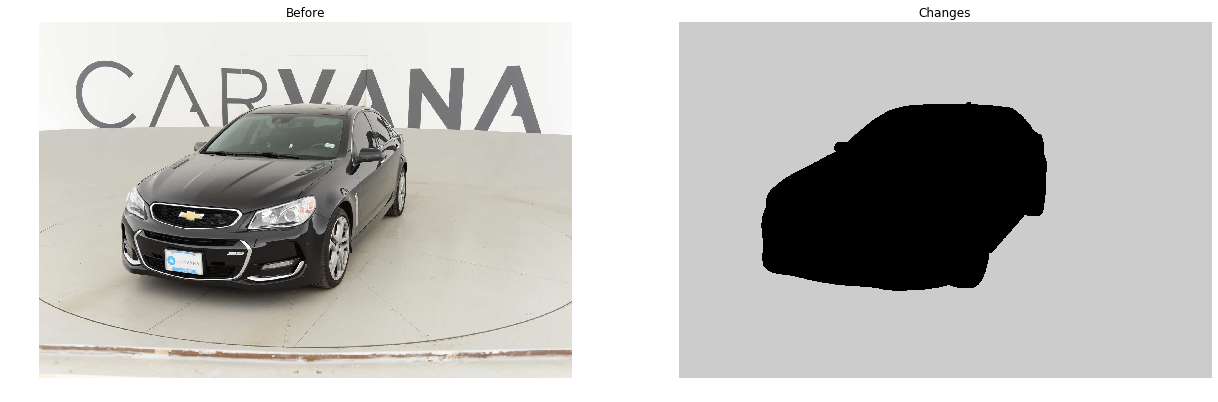

In [4]:
def read_diff_img(c_row):
    t0_img = imread(c_row['path'])[:,:,0:3]
    cg_img = imread(c_row['mask_path'], as_gray=True)
    return (t0_img, cg_img)
def make_change_figure(c_row):
    a,c = read_diff_img(c_row)
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (21,7))
    ax1.imshow(a)
    ax1.set_title('Before')
    ax1.axis('off')
    d = skimage.measure.label(c)
    ax3.imshow(d, cmap = 'nipy_spectral_r')
    ax3.set_title('Changes')
    ax3.axis('off')
    return fig
_, t_row = next(all_img_df.sample(1).iterrows())
make_change_figure(t_row).savefig('overview.png', dpi = 300)
a,c = read_diff_img(t_row)
print(a.shape, c.shape)

# Training and Validation Split
Here we split based on scene so the model doesn't overfit the individual images

In [5]:
from sklearn.model_selection import train_test_split
def train_test_split_on_group(in_df, col_id, **kwargs):
    group_val = np.unique(in_df[col_id])
    train_ids, test_ids = train_test_split(group_val, **kwargs)
    return in_df[in_df[col_id].isin(train_ids)], in_df[in_df[col_id].isin(test_ids)],
train_df, valid_df = train_test_split_on_group(all_img_df, col_id = 'car_id', random_state = 2018, test_size = 0.2)
valid_df, test_df = train_test_split_on_group(valid_df, col_id = 'car_id', random_state = 2018, test_size = 0.5)
print(train_df.shape[0], 'training images')
print(valid_df.shape[0], 'validation images')
print(test_df.shape[0], 'test images')

4064 training images
512 validation images
512 test images


# Augmenting Data

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.01, 
                  height_shift_range = 0.01, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.1],  
                  horizontal_flip = True, 
                  vertical_flip = False, # no upside down cars
                  fill_mode = 'nearest',
                   data_format = 'channels_last',
               preprocessing_function = preprocess_input)
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
default_batch_size = 8
core_idg = ImageDataGenerator(**dg_args)
mask_args = dg_args.copy()
mask_args['preprocessing_function'] = lambda x: x/255.0
mask_idg = ImageDataGenerator(**mask_args)

Using TensorFlow backend.


In [7]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [8]:
def make_gen(img_gen, mask_gen, in_df, batch_size = default_batch_size, seed = None, shuffle = True):
    if seed is None:
        seed = np.random.choice(range(9999))
    flow_args = dict(target_size = IMG_SIZE, 
                     batch_size = batch_size, 
                     seed = seed,
                     shuffle = shuffle,
                    y_col = 'key_id')
    t0_gen = flow_from_dataframe(img_gen, in_df, 
                                 path_col = 'path',
                                 color_mode = 'rgb',
                                **flow_args)
    dm_gen = flow_from_dataframe(mask_gen, in_df, 
                                 path_col = 'mask_path',
                                 color_mode = 'grayscale',
                                **flow_args)
    for (t0_img, _), (dm_img, _) in zip(t0_gen, dm_gen):
        yield [t0_img], dm_img

train_gen = make_gen(core_idg, mask_idg, train_df)
valid_gen = make_gen(core_idg, mask_idg, valid_df, seed = 0, shuffle = False)
test_gen = make_gen(core_idg, mask_idg, test_df, seed = 0, shuffle = False, batch_size = 2*default_batch_size)
[t0_img], dm_img = next(train_gen)
print(t0_img.shape, t0_img.max())
print(dm_img.shape, dm_img.max(), dm_img.mean())

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4064 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.


Reinserting dataframe: 4064 images


(8, 512, 512, 3) 151.061
(8, 512, 512, 1) 1.0 0.22220604


/home/wei005/anaconda3/envs/icnet/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/wei005/anaconda3/envs/icnet/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/wei005/anaconda3/envs/icnet/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/wei005/anaconda3/envs/icnet/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``mon

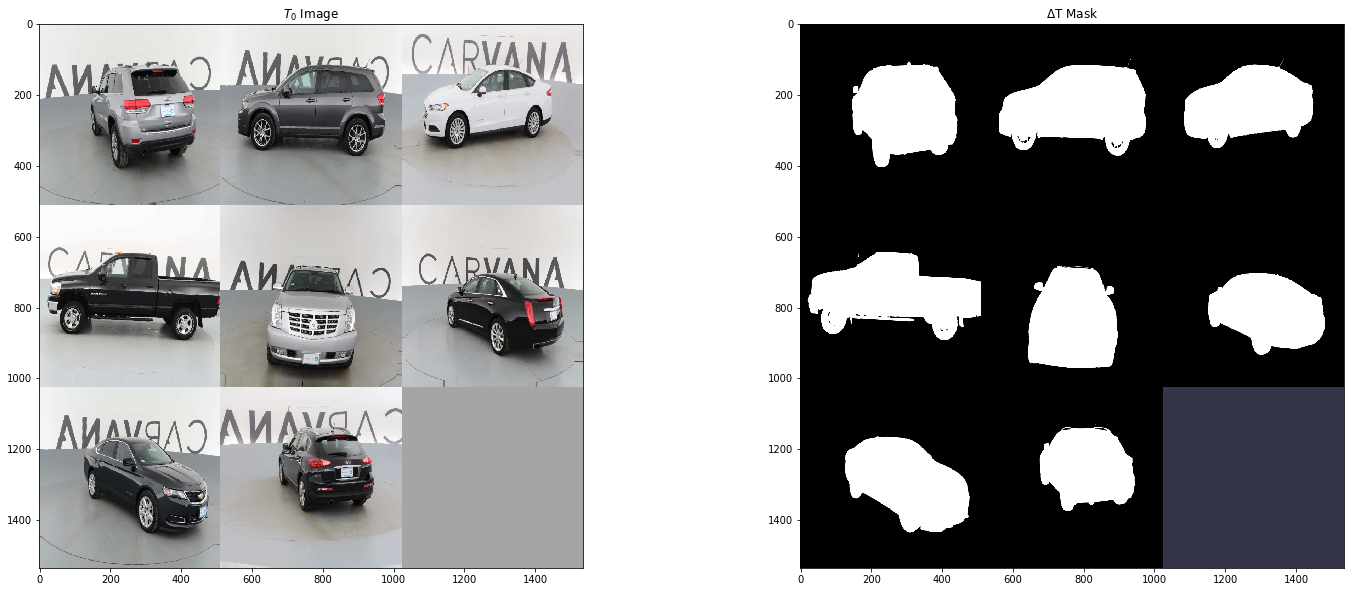

In [11]:
n_rgb = lambda x: np.stack([(x[:, :, i]-x[:, :, i].min())/(x[:, :, i].max()-x[:, :, i].min()) for i in range(x.shape[2])], 2)[:, :, ::-1]
nn_rgb = lambda x: n_rgb(np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1))
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (25, 10))
ax1.imshow(nn_rgb(t0_img[:, :, :, :]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage2d(dm_img[:, :, :, 0]), cmap = 'bone')
ax3.set_title('$\Delta$T Mask');

# Building the Model

In [13]:
from keras.applications.vgg16 import VGG16 as PTModel
base_pretrained_model = PTModel(input_shape =  t0_img.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
base_pretrained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

## Collect Interesting Layers for Model
Here we collect layers by size so we can make an encoder from them

In [14]:
from collections import defaultdict, OrderedDict
from keras.models import Model
layer_size_dict = defaultdict(list)
inputs = []
for lay_idx, c_layer in enumerate(base_pretrained_model.layers):
    if not c_layer.__class__.__name__ == 'InputLayer':
        layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
    else:
        inputs += [c_layer]
# freeze dict
layer_size_dict = OrderedDict(layer_size_dict.items())
for k,v in layer_size_dict.items():
    print(k, [w.__class__.__name__ for w in v])

(512, 512) ['Conv2D', 'Conv2D']
(256, 256) ['MaxPooling2D', 'Conv2D', 'Conv2D']
(128, 128) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(64, 64) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(32, 32) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(16, 16) ['MaxPooling2D']


In [16]:
%%time
# take the last layer of each shape and make it into an output
pretrained_encoder = Model(inputs = base_pretrained_model.get_input_at(0), 
                           outputs = [v[-1].get_output_at(0) for k, v in layer_size_dict.items()])
pretrained_encoder.trainable = False
n_outputs = pretrained_encoder.predict([t0_img])
for c_out, (k, v) in zip(n_outputs, layer_size_dict.items()):
    print(c_out.shape, 'expected', k)

(8, 512, 512, 64) expected (512, 512)
(8, 256, 256, 128) expected (256, 256)
(8, 128, 128, 256) expected (128, 128)
(8, 64, 64, 512) expected (64, 64)
(8, 32, 32, 512) expected (32, 32)
(8, 16, 16, 512) expected (16, 16)
CPU times: user 2.96 s, sys: 1.32 s, total: 4.27 s
Wall time: 1.13 s


# Build the U-Net

In [18]:
from keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation, Cropping2D, ZeroPadding2D
x_wid, y_wid = t0_img.shape[1:3]
in_t0 = Input(t0_img.shape[1:], name = 'T0_Image')
wrap_encoder = lambda i_layer: {k: v for k, v in zip(layer_size_dict.keys(), pretrained_encoder(i_layer))}

t0_outputs = wrap_encoder(in_t0)
lay_dims = sorted(t0_outputs.keys(), key = lambda x: x[0])
skip_layers = 2
last_layer = None
for k in lay_dims[skip_layers:]:
    cur_layer = t0_outputs[k]
    channel_count = cur_layer._keras_shape[-1]
    cur_layer = Conv2D(channel_count//2, kernel_size=(3,3), padding = 'same', activation = 'linear')(cur_layer)
    cur_layer = BatchNormalization()(cur_layer) # gotta keep an eye on that internal covariant shift
    cur_layer = Activation('relu')(cur_layer)
    
    if last_layer is None:
        x = cur_layer
    else:
        last_channel_count = last_layer._keras_shape[-1]
        x = Conv2D(last_channel_count//2, kernel_size=(3,3), padding = 'same')(last_layer)
        x = UpSampling2D((2, 2))(x)
        x = concatenate([cur_layer, x])
    last_layer = x
final_output = Conv2D(dm_img.shape[-1], kernel_size=(1,1), padding = 'same', activation = 'sigmoid')(last_layer)
crop_size = 20
final_output = Cropping2D((crop_size, crop_size))(final_output)
final_output = ZeroPadding2D((crop_size, crop_size))(final_output)
unet_model = Model(inputs = [in_t0],
                  outputs = [final_output])
unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T0_Image (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 512, 512, 64 14714688    T0_Image[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 256)  1179904     model_2[2][3]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 64, 64, 256)  1024        conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 

In [20]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

unet_model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss=dice_p_bce, 
                   metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
loss_history = []

## Callbacks for training
Make sure the training works well and doesnt run too long or overfit too much

In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('vgg_unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/wei005/anaconda3/envs/icnet/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [26]:
loss_history += [unet_model.fit_generator(make_gen(core_idg, mask_idg, train_df), 
                                         steps_per_epoch=min(100, train_df.shape[0]//t0_img.shape[0]), 
                                         epochs = 5, 
                                         validation_data = valid_gen,
                                          validation_steps = valid_df.shape[0]//t0_img.shape[0],
                                         callbacks = callbacks_list,
                                        workers = 1
                                       )]

Epoch 1/5
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4064 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.


Reinserting dataframe: 4064 images


  1/100 [..............................] - ETA: 3:27 - loss: -0.4013 - dice_coef: 0.4013 - binary_accuracy: 0.3546 - true_positive_rate: 1.0000

  2/100 [..............................] - ETA: 3:03 - loss: -0.4345 - dice_coef: 0.4345 - binary_accuracy: 0.4772 - true_positive_rate: 0.9487

  3/100 [..............................] - ETA: 2:55 - loss: -0.5022 - dice_coef: 0.5022 - binary_accuracy: 0.5688 - true_positive_rate: 0.9475

  4/100 [>.............................] - ETA: 2:47 - loss: -0.5240 - dice_coef: 0.5240 - binary_accuracy: 0.6218 - true_positive_rate: 0.8749

  5/100 [>.............................] - ETA: 2:41 - loss: -0.5521 - dice_coef: 0.5522 - binary_accuracy: 0.6589 - true_positive_rate: 0.8808

  6/100 [>.............................] - ETA: 2:33 - loss: -0.5665 - dice_coef: 0.5665 - binary_accuracy: 0.6830 - true_positive_rate: 0.8843

  7/100 [=>............................] - ETA: 2:31 - loss: -0.5921 - dice_coef: 0.5921 - binary_accuracy: 0.7094 - true_positive_rate: 0.8906

  8/100 [=>............................] - ETA: 2:27 - loss: -0.6219 - dice_coef: 0.6219 - binary_accuracy: 0.7330 - true_positive_rate: 0.8933

  9/100 [=>............................] - ETA: 2:23 - loss: -0.6399 - dice_coef: 0.6399 - binary_accuracy: 0.7509 - true_positive_rate: 0.8918

 10/100 [==>...........................] - ETA: 2:20 - loss: -0.6560 - dice_coef: 0.6560 - binary_accuracy: 0.7678 - true_positive_rate: 0.8867

 11/100 [==>...........................] - ETA: 2:17 - loss: -0.6714 - dice_coef: 0.6714 - binary_accuracy: 0.7816 - true_positive_rate: 0.8807

 12/100 [==>...........................] - ETA: 2:14 - loss: -0.6922 - dice_coef: 0.6922 - binary_accuracy: 0.7965 - true_positive_rate: 0.8825

 13/100 [==>...........................] - ETA: 2:10 - loss: -0.7079 - dice_coef: 0.7079 - binary_accuracy: 0.8088 - true_positive_rate: 0.8870

 14/100 [===>..........................] - ETA: 2:06 - loss: -0.7242 - dice_coef: 0.7242 - binary_accuracy: 0.8204 - true_positive_rate: 0.8937

 15/100 [===>..........................] - ETA: 2:01 - loss: -0.7384 - dice_coef: 0.7384 - binary_accuracy: 0.8300 - true_positive_rate: 0.8967

 16/100 [===>..........................] - ETA: 1:57 - loss: -0.7510 - dice_coef: 0.7510 - binary_accuracy: 0.8389 - true_positive_rate: 0.9015

 17/100 [====>.........................] - ETA: 1:53 - loss: -0.7618 - dice_coef: 0.7618 - binary_accuracy: 0.8465 - true_positive_rate: 0.9053

 18/100 [====>.........................] - ETA: 1:50 - loss: -0.7722 - dice_coef: 0.7722 - binary_accuracy: 0.8537 - true_positive_rate: 0.9086

 19/100 [====>.........................] - ETA: 1:46 - loss: -0.7814 - dice_coef: 0.7814 - binary_accuracy: 0.8601 - true_positive_rate: 0.9109

 20/100 [=====>........................] - ETA: 1:45 - loss: -0.7898 - dice_coef: 0.7898 - binary_accuracy: 0.8661 - true_positive_rate: 0.9126

 21/100 [=====>........................] - ETA: 1:43 - loss: -0.7975 - dice_coef: 0.7975 - binary_accuracy: 0.8714 - true_positive_rate: 0.9141

 22/100 [=====>........................] - ETA: 1:40 - loss: -0.8050 - dice_coef: 0.8050 - binary_accuracy: 0.8765 - true_positive_rate: 0.9158

 23/100 [=====>........................] - ETA: 1:38 - loss: -0.8115 - dice_coef: 0.8115 - binary_accuracy: 0.8810 - true_positive_rate: 0.9166

 24/100 [======>.......................] - ETA: 1:35 - loss: -0.8178 - dice_coef: 0.8178 - binary_accuracy: 0.8851 - true_positive_rate: 0.9176

 25/100 [======>.......................] - ETA: 1:33 - loss: -0.8236 - dice_coef: 0.8236 - binary_accuracy: 0.8890 - true_positive_rate: 0.9194

 26/100 [======>.......................] - ETA: 1:31 - loss: -0.8288 - dice_coef: 0.8288 - binary_accuracy: 0.8924 - true_positive_rate: 0.9204

 27/100 [=======>......................] - ETA: 1:29 - loss: -0.8333 - dice_coef: 0.8333 - binary_accuracy: 0.8955 - true_positive_rate: 0.9216

 28/100 [=======>......................] - ETA: 1:27 - loss: -0.8379 - dice_coef: 0.8379 - binary_accuracy: 0.8984 - true_positive_rate: 0.9229

 29/100 [=======>......................] - ETA: 1:25 - loss: -0.8421 - dice_coef: 0.8421 - binary_accuracy: 0.9012 - true_positive_rate: 0.9247

 30/100 [========>.....................] - ETA: 1:23 - loss: -0.8462 - dice_coef: 0.8462 - binary_accuracy: 0.9040 - true_positive_rate: 0.9267

 31/100 [========>.....................] - ETA: 1:21 - loss: -0.8500 - dice_coef: 0.8500 - binary_accuracy: 0.9066 - true_positive_rate: 0.9283

 32/100 [========>.....................] - ETA: 1:20 - loss: -0.8537 - dice_coef: 0.8537 - binary_accuracy: 0.9089 - true_positive_rate: 0.9298

 33/100 [========>.....................] - ETA: 1:18 - loss: -0.8572 - dice_coef: 0.8572 - binary_accuracy: 0.9113 - true_positive_rate: 0.9313

 34/100 [=========>....................] - ETA: 1:16 - loss: -0.8605 - dice_coef: 0.8605 - binary_accuracy: 0.9134 - true_positive_rate: 0.9323

 35/100 [=========>....................] - ETA: 1:14 - loss: -0.8638 - dice_coef: 0.8638 - binary_accuracy: 0.9154 - true_positive_rate: 0.9331

 36/100 [=========>....................] - ETA: 1:14 - loss: -0.8665 - dice_coef: 0.8665 - binary_accuracy: 0.9172 - true_positive_rate: 0.9334

 37/100 [==========>...................] - ETA: 1:13 - loss: -0.8690 - dice_coef: 0.8690 - binary_accuracy: 0.9188 - true_positive_rate: 0.9335

 38/100 [==========>...................] - ETA: 1:12 - loss: -0.8716 - dice_coef: 0.8716 - binary_accuracy: 0.9205 - true_positive_rate: 0.9343

 39/100 [==========>...................] - ETA: 1:11 - loss: -0.8742 - dice_coef: 0.8742 - binary_accuracy: 0.9222 - true_positive_rate: 0.9354

 40/100 [===========>..................] - ETA: 1:10 - loss: -0.8767 - dice_coef: 0.8767 - binary_accuracy: 0.9238 - true_positive_rate: 0.9363

 41/100 [===========>..................] - ETA: 1:08 - loss: -0.8790 - dice_coef: 0.8790 - binary_accuracy: 0.9252 - true_positive_rate: 0.9373

 42/100 [===========>..................] - ETA: 1:07 - loss: -0.8811 - dice_coef: 0.8811 - binary_accuracy: 0.9266 - true_positive_rate: 0.9383

 43/100 [===========>..................] - ETA: 1:06 - loss: -0.8830 - dice_coef: 0.8830 - binary_accuracy: 0.9279 - true_positive_rate: 0.9394

 44/100 [============>.................] - ETA: 1:04 - loss: -0.8850 - dice_coef: 0.8850 - binary_accuracy: 0.9292 - true_positive_rate: 0.9403

 45/100 [============>.................] - ETA: 1:03 - loss: -0.8869 - dice_coef: 0.8869 - binary_accuracy: 0.9304 - true_positive_rate: 0.9414

 46/100 [============>.................] - ETA: 1:02 - loss: -0.8887 - dice_coef: 0.8887 - binary_accuracy: 0.9316 - true_positive_rate: 0.9421

 47/100 [=============>................] - ETA: 1:00 - loss: -0.8901 - dice_coef: 0.8901 - binary_accuracy: 0.9324 - true_positive_rate: 0.9414

 48/100 [=============>................] - ETA: 59s - loss: -0.8919 - dice_coef: 0.8919 - binary_accuracy: 0.9335 - true_positive_rate: 0.9421 

 49/100 [=============>................] - ETA: 57s - loss: -0.8936 - dice_coef: 0.8936 - binary_accuracy: 0.9346 - true_positive_rate: 0.9426

 50/100 [==============>...............] - ETA: 56s - loss: -0.8952 - dice_coef: 0.8952 - binary_accuracy: 0.9357 - true_positive_rate: 0.9432

 51/100 [==============>...............] - ETA: 55s - loss: -0.8968 - dice_coef: 0.8968 - binary_accuracy: 0.9367 - true_positive_rate: 0.9437

 52/100 [==============>...............] - ETA: 54s - loss: -0.8983 - dice_coef: 0.8983 - binary_accuracy: 0.9377 - true_positive_rate: 0.9443

 53/100 [==============>...............] - ETA: 53s - loss: -0.8997 - dice_coef: 0.8997 - binary_accuracy: 0.9386 - true_positive_rate: 0.9448

 54/100 [===============>..............] - ETA: 52s - loss: -0.9012 - dice_coef: 0.9012 - binary_accuracy: 0.9395 - true_positive_rate: 0.9455

 55/100 [===============>..............] - ETA: 51s - loss: -0.9026 - dice_coef: 0.9026 - binary_accuracy: 0.9404 - true_positive_rate: 0.9462

 56/100 [===============>..............] - ETA: 50s - loss: -0.9038 - dice_coef: 0.9038 - binary_accuracy: 0.9411 - true_positive_rate: 0.9463

 57/100 [================>.............] - ETA: 49s - loss: -0.9050 - dice_coef: 0.9050 - binary_accuracy: 0.9419 - true_positive_rate: 0.9469

 58/100 [================>.............] - ETA: 48s - loss: -0.9060 - dice_coef: 0.9060 - binary_accuracy: 0.9426 - true_positive_rate: 0.9472

 59/100 [================>.............] - ETA: 46s - loss: -0.9072 - dice_coef: 0.9072 - binary_accuracy: 0.9434 - true_positive_rate: 0.9476

 60/100 [=================>............] - ETA: 45s - loss: -0.9083 - dice_coef: 0.9083 - binary_accuracy: 0.9441 - true_positive_rate: 0.9482

 61/100 [=================>............] - ETA: 44s - loss: -0.9095 - dice_coef: 0.9095 - binary_accuracy: 0.9448 - true_positive_rate: 0.9485

 62/100 [=================>............] - ETA: 43s - loss: -0.9106 - dice_coef: 0.9106 - binary_accuracy: 0.9455 - true_positive_rate: 0.9489

 63/100 [=================>............] - ETA: 41s - loss: -0.9116 - dice_coef: 0.9116 - binary_accuracy: 0.9462 - true_positive_rate: 0.9494

 64/100 [==================>...........] - ETA: 40s - loss: -0.9127 - dice_coef: 0.9127 - binary_accuracy: 0.9468 - true_positive_rate: 0.9499

 65/100 [==================>...........] - ETA: 39s - loss: -0.9138 - dice_coef: 0.9138 - binary_accuracy: 0.9475 - true_positive_rate: 0.9505

 66/100 [==================>...........] - ETA: 38s - loss: -0.9147 - dice_coef: 0.9147 - binary_accuracy: 0.9481 - true_positive_rate: 0.9509

 67/100 [===================>..........] - ETA: 36s - loss: -0.9156 - dice_coef: 0.9156 - binary_accuracy: 0.9487 - true_positive_rate: 0.9513

 68/100 [===================>..........] - ETA: 35s - loss: -0.9166 - dice_coef: 0.9166 - binary_accuracy: 0.9492 - true_positive_rate: 0.9518

 69/100 [===================>..........] - ETA: 34s - loss: -0.9175 - dice_coef: 0.9175 - binary_accuracy: 0.9498 - true_positive_rate: 0.9522

 70/100 [====================>.........] - ETA: 33s - loss: -0.9183 - dice_coef: 0.9183 - binary_accuracy: 0.9504 - true_positive_rate: 0.9527

 71/100 [====================>.........] - ETA: 32s - loss: -0.9191 - dice_coef: 0.9191 - binary_accuracy: 0.9509 - true_positive_rate: 0.9530

 72/100 [====================>.........] - ETA: 30s - loss: -0.9198 - dice_coef: 0.9198 - binary_accuracy: 0.9513 - true_positive_rate: 0.9530

 73/100 [====================>.........] - ETA: 29s - loss: -0.9206 - dice_coef: 0.9206 - binary_accuracy: 0.9518 - true_positive_rate: 0.9533

 74/100 [=====================>........] - ETA: 28s - loss: -0.9214 - dice_coef: 0.9214 - binary_accuracy: 0.9523 - true_positive_rate: 0.9537

 75/100 [=====================>........] - ETA: 27s - loss: -0.9222 - dice_coef: 0.9222 - binary_accuracy: 0.9528 - true_positive_rate: 0.9540

 76/100 [=====================>........] - ETA: 26s - loss: -0.9230 - dice_coef: 0.9230 - binary_accuracy: 0.9533 - true_positive_rate: 0.9543

 77/100 [======================>.......] - ETA: 25s - loss: -0.9237 - dice_coef: 0.9237 - binary_accuracy: 0.9537 - true_positive_rate: 0.9547

 78/100 [======================>.......] - ETA: 24s - loss: -0.9244 - dice_coef: 0.9244 - binary_accuracy: 0.9541 - true_positive_rate: 0.9549

 79/100 [======================>.......] - ETA: 23s - loss: -0.9250 - dice_coef: 0.9250 - binary_accuracy: 0.9546 - true_positive_rate: 0.9552

 80/100 [=======================>......] - ETA: 21s - loss: -0.9258 - dice_coef: 0.9258 - binary_accuracy: 0.9550 - true_positive_rate: 0.9555

 81/100 [=======================>......] - ETA: 20s - loss: -0.9264 - dice_coef: 0.9264 - binary_accuracy: 0.9554 - true_positive_rate: 0.9559

 82/100 [=======================>......] - ETA: 19s - loss: -0.9271 - dice_coef: 0.9271 - binary_accuracy: 0.9559 - true_positive_rate: 0.9562

 83/100 [=======================>......] - ETA: 18s - loss: -0.9277 - dice_coef: 0.9277 - binary_accuracy: 0.9563 - true_positive_rate: 0.9565

 84/100 [========================>.....] - ETA: 17s - loss: -0.9283 - dice_coef: 0.9283 - binary_accuracy: 0.9567 - true_positive_rate: 0.9567

 85/100 [========================>.....] - ETA: 16s - loss: -0.9289 - dice_coef: 0.9290 - binary_accuracy: 0.9570 - true_positive_rate: 0.9569

 86/100 [========================>.....] - ETA: 15s - loss: -0.9295 - dice_coef: 0.9295 - binary_accuracy: 0.9573 - true_positive_rate: 0.9571

 87/100 [=========================>....] - ETA: 14s - loss: -0.9301 - dice_coef: 0.9301 - binary_accuracy: 0.9577 - true_positive_rate: 0.9573

 88/100 [=========================>....] - ETA: 12s - loss: -0.9306 - dice_coef: 0.9306 - binary_accuracy: 0.9580 - true_positive_rate: 0.9576

 89/100 [=========================>....] - ETA: 11s - loss: -0.9311 - dice_coef: 0.9311 - binary_accuracy: 0.9583 - true_positive_rate: 0.9578

 90/100 [==========================>...] - ETA: 10s - loss: -0.9316 - dice_coef: 0.9316 - binary_accuracy: 0.9587 - true_positive_rate: 0.9580

 91/100 [==========================>...] - ETA: 9s - loss: -0.9321 - dice_coef: 0.9321 - binary_accuracy: 0.9590 - true_positive_rate: 0.9584 

 92/100 [==========================>...] - ETA: 8s - loss: -0.9326 - dice_coef: 0.9326 - binary_accuracy: 0.9593 - true_positive_rate: 0.9586

 93/100 [==========================>...] - ETA: 7s - loss: -0.9332 - dice_coef: 0.9332 - binary_accuracy: 0.9596 - true_positive_rate: 0.9589

 94/100 [===========================>..] - ETA: 6s - loss: -0.9337 - dice_coef: 0.9337 - binary_accuracy: 0.9599 - true_positive_rate: 0.9591

 95/100 [===========================>..] - ETA: 5s - loss: -0.9341 - dice_coef: 0.9341 - binary_accuracy: 0.9602 - true_positive_rate: 0.9592

 96/100 [===========================>..] - ETA: 4s - loss: -0.9346 - dice_coef: 0.9346 - binary_accuracy: 0.9605 - true_positive_rate: 0.9594

 97/100 [============================>.] - ETA: 3s - loss: -0.9351 - dice_coef: 0.9351 - binary_accuracy: 0.9608 - true_positive_rate: 0.9594

 98/100 [============================>.] - ETA: 2s - loss: -0.9356 - dice_coef: 0.9356 - binary_accuracy: 0.9611 - true_positive_rate: 0.9597

 99/100 [============================>.] - ETA: 1s - loss: -0.9361 - dice_coef: 0.9361 - binary_accuracy: 0.9614 - true_positive_rate: 0.9600

100/100 [==============================] - 167s 2s/step - loss: -0.9365 - dice_coef: 0.9365 - binary_accuracy: 0.9616 - true_positive_rate: 0.9602 - val_loss: -0.9305 - val_dice_coef: 0.9305 - val_binary_accuracy: 0.9689 - val_true_positive_rate: 0.9361



Epoch 00001: val_loss improved from inf to -0.93049, saving model to vgg_unet_weights.best.hdf5


Epoch 2/5


  1/100 [..............................] - ETA: 35s - loss: -0.9026 - dice_coef: 0.9026 - binary_accuracy: 0.9578 - true_positive_rate: 0.9090

  2/100 [..............................] - ETA: 34s - loss: -0.8689 - dice_coef: 0.8689 - binary_accuracy: 0.9443 - true_positive_rate: 0.8709

  3/100 [..............................] - ETA: 34s - loss: -0.8619 - dice_coef: 0.8619 - binary_accuracy: 0.9403 - true_positive_rate: 0.8659

  4/100 [>.............................] - ETA: 34s - loss: -0.8494 - dice_coef: 0.8494 - binary_accuracy: 0.9353 - true_positive_rate: 0.8509

  5/100 [>.............................] - ETA: 34s - loss: -0.8455 - dice_coef: 0.8455 - binary_accuracy: 0.9323 - true_positive_rate: 0.8429

  6/100 [>.............................] - ETA: 34s - loss: -0.8481 - dice_coef: 0.8481 - binary_accuracy: 0.9338 - true_positive_rate: 0.8462

  7/100 [=>............................] - ETA: 33s - loss: -0.8492 - dice_coef: 0.8492 - binary_accuracy: 0.9307 - true_positive_rate: 0.8380

  8/100 [=>............................] - ETA: 33s - loss: -0.8512 - dice_coef: 0.8512 - binary_accuracy: 0.9326 - true_positive_rate: 0.8449

  9/100 [=>............................] - ETA: 32s - loss: -0.8529 - dice_coef: 0.8529 - binary_accuracy: 0.9347 - true_positive_rate: 0.8500

 10/100 [==>...........................] - ETA: 32s - loss: -0.8512 - dice_coef: 0.8512 - binary_accuracy: 0.9337 - true_positive_rate: 0.8484

 11/100 [==>...........................] - ETA: 32s - loss: -0.8527 - dice_coef: 0.8527 - binary_accuracy: 0.9343 - true_positive_rate: 0.8517

 12/100 [==>...........................] - ETA: 31s - loss: -0.8492 - dice_coef: 0.8492 - binary_accuracy: 0.9323 - true_positive_rate: 0.8518

 13/100 [==>...........................] - ETA: 31s - loss: -0.8514 - dice_coef: 0.8514 - binary_accuracy: 0.9336 - true_positive_rate: 0.8577

 14/100 [===>..........................] - ETA: 31s - loss: -0.8525 - dice_coef: 0.8525 - binary_accuracy: 0.9331 - true_positive_rate: 0.8585

 15/100 [===>..........................] - ETA: 34s - loss: -0.8499 - dice_coef: 0.8499 - binary_accuracy: 0.9314 - true_positive_rate: 0.8546

 16/100 [===>..........................] - ETA: 38s - loss: -0.8546 - dice_coef: 0.8546 - binary_accuracy: 0.9336 - true_positive_rate: 0.8605

 17/100 [====>.........................] - ETA: 42s - loss: -0.8515 - dice_coef: 0.8515 - binary_accuracy: 0.9317 - true_positive_rate: 0.8570

 18/100 [====>.........................] - ETA: 47s - loss: -0.8491 - dice_coef: 0.8491 - binary_accuracy: 0.9307 - true_positive_rate: 0.8526

 19/100 [====>.........................] - ETA: 49s - loss: -0.8542 - dice_coef: 0.8542 - binary_accuracy: 0.9330 - true_positive_rate: 0.8580

 20/100 [=====>........................] - ETA: 51s - loss: -0.8549 - dice_coef: 0.8549 - binary_accuracy: 0.9330 - true_positive_rate: 0.8594

 21/100 [=====>........................] - ETA: 53s - loss: -0.8534 - dice_coef: 0.8534 - binary_accuracy: 0.9324 - true_positive_rate: 0.8580

 22/100 [=====>........................] - ETA: 55s - loss: -0.8529 - dice_coef: 0.8529 - binary_accuracy: 0.9325 - true_positive_rate: 0.8582

 23/100 [=====>........................] - ETA: 55s - loss: -0.8523 - dice_coef: 0.8523 - binary_accuracy: 0.9321 - true_positive_rate: 0.8578

 24/100 [======>.......................] - ETA: 55s - loss: -0.8576 - dice_coef: 0.8576 - binary_accuracy: 0.9344 - true_positive_rate: 0.8630

 25/100 [======>.......................] - ETA: 55s - loss: -0.8625 - dice_coef: 0.8625 - binary_accuracy: 0.9366 - true_positive_rate: 0.8679

 26/100 [======>.......................] - ETA: 55s - loss: -0.8668 - dice_coef: 0.8668 - binary_accuracy: 0.9385 - true_positive_rate: 0.8718

 27/100 [=======>......................] - ETA: 54s - loss: -0.8710 - dice_coef: 0.8710 - binary_accuracy: 0.9403 - true_positive_rate: 0.8758

 28/100 [=======>......................] - ETA: 54s - loss: -0.8747 - dice_coef: 0.8747 - binary_accuracy: 0.9420 - true_positive_rate: 0.8792

 29/100 [=======>......................] - ETA: 54s - loss: -0.8782 - dice_coef: 0.8782 - binary_accuracy: 0.9436 - true_positive_rate: 0.8824

 30/100 [========>.....................] - ETA: 53s - loss: -0.8816 - dice_coef: 0.8816 - binary_accuracy: 0.9451 - true_positive_rate: 0.8857

 31/100 [========>.....................] - ETA: 53s - loss: -0.8846 - dice_coef: 0.8846 - binary_accuracy: 0.9464 - true_positive_rate: 0.8884

 32/100 [========>.....................] - ETA: 52s - loss: -0.8875 - dice_coef: 0.8875 - binary_accuracy: 0.9477 - true_positive_rate: 0.8914

 33/100 [========>.....................] - ETA: 52s - loss: -0.8904 - dice_coef: 0.8904 - binary_accuracy: 0.9490 - true_positive_rate: 0.8940

 34/100 [=========>....................] - ETA: 51s - loss: -0.8931 - dice_coef: 0.8931 - binary_accuracy: 0.9502 - true_positive_rate: 0.8965

 35/100 [=========>....................] - ETA: 51s - loss: -0.8956 - dice_coef: 0.8956 - binary_accuracy: 0.9513 - true_positive_rate: 0.8990

 36/100 [=========>....................] - ETA: 50s - loss: -0.8980 - dice_coef: 0.8980 - binary_accuracy: 0.9523 - true_positive_rate: 0.9010

 37/100 [==========>...................] - ETA: 50s - loss: -0.9002 - dice_coef: 0.9002 - binary_accuracy: 0.9533 - true_positive_rate: 0.9033

 38/100 [==========>...................] - ETA: 49s - loss: -0.9024 - dice_coef: 0.9023 - binary_accuracy: 0.9542 - true_positive_rate: 0.9056

 39/100 [==========>...................] - ETA: 48s - loss: -0.9044 - dice_coef: 0.9044 - binary_accuracy: 0.9552 - true_positive_rate: 0.9077

 40/100 [===========>..................] - ETA: 48s - loss: -0.9064 - dice_coef: 0.9064 - binary_accuracy: 0.9560 - true_positive_rate: 0.9097

 41/100 [===========>..................] - ETA: 47s - loss: -0.9083 - dice_coef: 0.9083 - binary_accuracy: 0.9569 - true_positive_rate: 0.9115

 42/100 [===========>..................] - ETA: 46s - loss: -0.9099 - dice_coef: 0.9099 - binary_accuracy: 0.9576 - true_positive_rate: 0.9130

 43/100 [===========>..................] - ETA: 46s - loss: -0.9115 - dice_coef: 0.9115 - binary_accuracy: 0.9583 - true_positive_rate: 0.9143

 44/100 [============>.................] - ETA: 45s - loss: -0.9132 - dice_coef: 0.9132 - binary_accuracy: 0.9590 - true_positive_rate: 0.9159

 45/100 [============>.................] - ETA: 44s - loss: -0.9146 - dice_coef: 0.9146 - binary_accuracy: 0.9596 - true_positive_rate: 0.9171

 46/100 [============>.................] - ETA: 44s - loss: -0.9161 - dice_coef: 0.9161 - binary_accuracy: 0.9603 - true_positive_rate: 0.9185

 47/100 [=============>................] - ETA: 44s - loss: -0.9175 - dice_coef: 0.9175 - binary_accuracy: 0.9610 - true_positive_rate: 0.9198

 48/100 [=============>................] - ETA: 43s - loss: -0.9188 - dice_coef: 0.9188 - binary_accuracy: 0.9616 - true_positive_rate: 0.9213

 49/100 [=============>................] - ETA: 43s - loss: -0.9201 - dice_coef: 0.9201 - binary_accuracy: 0.9622 - true_positive_rate: 0.9227

 50/100 [==============>...............] - ETA: 42s - loss: -0.9213 - dice_coef: 0.9213 - binary_accuracy: 0.9627 - true_positive_rate: 0.9239

 51/100 [==============>...............] - ETA: 42s - loss: -0.9225 - dice_coef: 0.9225 - binary_accuracy: 0.9632 - true_positive_rate: 0.9250

 52/100 [==============>...............] - ETA: 41s - loss: -0.9237 - dice_coef: 0.9237 - binary_accuracy: 0.9638 - true_positive_rate: 0.9261

 53/100 [==============>...............] - ETA: 40s - loss: -0.9248 - dice_coef: 0.9248 - binary_accuracy: 0.9643 - true_positive_rate: 0.9271

 54/100 [===============>..............] - ETA: 40s - loss: -0.9259 - dice_coef: 0.9259 - binary_accuracy: 0.9647 - true_positive_rate: 0.9280

 55/100 [===============>..............] - ETA: 39s - loss: -0.9269 - dice_coef: 0.9269 - binary_accuracy: 0.9652 - true_positive_rate: 0.9290

 56/100 [===============>..............] - ETA: 38s - loss: -0.9279 - dice_coef: 0.9279 - binary_accuracy: 0.9656 - true_positive_rate: 0.9299

 57/100 [================>.............] - ETA: 38s - loss: -0.9289 - dice_coef: 0.9289 - binary_accuracy: 0.9661 - true_positive_rate: 0.9310

 58/100 [================>.............] - ETA: 37s - loss: -0.9298 - dice_coef: 0.9298 - binary_accuracy: 0.9665 - true_positive_rate: 0.9319

 59/100 [================>.............] - ETA: 36s - loss: -0.9307 - dice_coef: 0.9307 - binary_accuracy: 0.9669 - true_positive_rate: 0.9327

 60/100 [=================>............] - ETA: 35s - loss: -0.9315 - dice_coef: 0.9315 - binary_accuracy: 0.9673 - true_positive_rate: 0.9334

 61/100 [=================>............] - ETA: 34s - loss: -0.9323 - dice_coef: 0.9323 - binary_accuracy: 0.9676 - true_positive_rate: 0.9341

 62/100 [=================>............] - ETA: 33s - loss: -0.9332 - dice_coef: 0.9332 - binary_accuracy: 0.9680 - true_positive_rate: 0.9350

 63/100 [=================>............] - ETA: 33s - loss: -0.9340 - dice_coef: 0.9340 - binary_accuracy: 0.9684 - true_positive_rate: 0.9357

 64/100 [==================>...........] - ETA: 32s - loss: -0.9348 - dice_coef: 0.9348 - binary_accuracy: 0.9687 - true_positive_rate: 0.9366

 65/100 [==================>...........] - ETA: 31s - loss: -0.9354 - dice_coef: 0.9354 - binary_accuracy: 0.9690 - true_positive_rate: 0.9371

 66/100 [==================>...........] - ETA: 30s - loss: -0.9362 - dice_coef: 0.9362 - binary_accuracy: 0.9693 - true_positive_rate: 0.9378

 67/100 [===================>..........] - ETA: 29s - loss: -0.9368 - dice_coef: 0.9368 - binary_accuracy: 0.9696 - true_positive_rate: 0.9385

 68/100 [===================>..........] - ETA: 28s - loss: -0.9375 - dice_coef: 0.9375 - binary_accuracy: 0.9699 - true_positive_rate: 0.9393

 69/100 [===================>..........] - ETA: 27s - loss: -0.9382 - dice_coef: 0.9382 - binary_accuracy: 0.9702 - true_positive_rate: 0.9399

 70/100 [====================>.........] - ETA: 27s - loss: -0.9389 - dice_coef: 0.9389 - binary_accuracy: 0.9705 - true_positive_rate: 0.9405

 71/100 [====================>.........] - ETA: 26s - loss: -0.9395 - dice_coef: 0.9395 - binary_accuracy: 0.9708 - true_positive_rate: 0.9412

 72/100 [====================>.........] - ETA: 25s - loss: -0.9401 - dice_coef: 0.9401 - binary_accuracy: 0.9711 - true_positive_rate: 0.9417

 73/100 [====================>.........] - ETA: 24s - loss: -0.9407 - dice_coef: 0.9407 - binary_accuracy: 0.9714 - true_positive_rate: 0.9422

 74/100 [=====================>........] - ETA: 23s - loss: -0.9413 - dice_coef: 0.9413 - binary_accuracy: 0.9716 - true_positive_rate: 0.9426

 75/100 [=====================>........] - ETA: 23s - loss: -0.9418 - dice_coef: 0.9418 - binary_accuracy: 0.9718 - true_positive_rate: 0.9430

 76/100 [=====================>........] - ETA: 22s - loss: -0.9424 - dice_coef: 0.9424 - binary_accuracy: 0.9721 - true_positive_rate: 0.9436

 77/100 [======================>.......] - ETA: 21s - loss: -0.9429 - dice_coef: 0.9429 - binary_accuracy: 0.9723 - true_positive_rate: 0.9442

 78/100 [======================>.......] - ETA: 20s - loss: -0.9434 - dice_coef: 0.9434 - binary_accuracy: 0.9725 - true_positive_rate: 0.9446

 79/100 [======================>.......] - ETA: 19s - loss: -0.9439 - dice_coef: 0.9439 - binary_accuracy: 0.9727 - true_positive_rate: 0.9451

 80/100 [=======================>......] - ETA: 18s - loss: -0.9443 - dice_coef: 0.9443 - binary_accuracy: 0.9729 - true_positive_rate: 0.9455

 81/100 [=======================>......] - ETA: 17s - loss: -0.9448 - dice_coef: 0.9448 - binary_accuracy: 0.9731 - true_positive_rate: 0.9460

 82/100 [=======================>......] - ETA: 16s - loss: -0.9454 - dice_coef: 0.9454 - binary_accuracy: 0.9733 - true_positive_rate: 0.9466

 83/100 [=======================>......] - ETA: 15s - loss: -0.9458 - dice_coef: 0.9458 - binary_accuracy: 0.9735 - true_positive_rate: 0.9470

 84/100 [========================>.....] - ETA: 14s - loss: -0.9463 - dice_coef: 0.9463 - binary_accuracy: 0.9738 - true_positive_rate: 0.9475

 85/100 [========================>.....] - ETA: 13s - loss: -0.9467 - dice_coef: 0.9467 - binary_accuracy: 0.9740 - true_positive_rate: 0.9479

 86/100 [========================>.....] - ETA: 13s - loss: -0.9472 - dice_coef: 0.9472 - binary_accuracy: 0.9742 - true_positive_rate: 0.9484

 87/100 [=========================>....] - ETA: 12s - loss: -0.9476 - dice_coef: 0.9476 - binary_accuracy: 0.9744 - true_positive_rate: 0.9488

 88/100 [=========================>....] - ETA: 11s - loss: -0.9480 - dice_coef: 0.9480 - binary_accuracy: 0.9746 - true_positive_rate: 0.9493

 89/100 [=========================>....] - ETA: 10s - loss: -0.9485 - dice_coef: 0.9485 - binary_accuracy: 0.9748 - true_positive_rate: 0.9497

In [25]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

ValueError: need at least one array to concatenate

In [ ]:
unet_model.load_weights(weight_path)
unet_model.save('full_seg_model.h5')

# Show the results

In [ ]:
[t0_img], dm_img = next(train_gen)
dm_pred = unet_model.predict([t0_img])
fig, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize = (40, 10))
ax1.imshow(montage2d(t0_img[:, :, :, 0]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage2d(dm_pred[:, :, :, 0]), cmap = 'nipy_spectral')
ax3.set_title('$\Delta$T Prediction');
ax4.imshow(montage2d(dm_img[:, :, :, 0]), cmap = 'bone')
ax4.set_title('$\Delta$T Mask');

In [ ]:
fig, m_axs = plt.subplots(5, 4, figsize = (40, 40))
for (ax1, ax3, ax4, ax5), x_t0, x_pred, x_dm in zip(m_axs, t0_img, dm_pred, dm_img):
    n_rgb = lambda x: np.stack([(x[:, :, i]-x[:, :, i].min())/(x[:, :, i].max()-x[:, :, i].min()) for i in range(x.shape[2])], 2)[:, :, ::-1]
    ax1.imshow(n_rgb(x_t0), cmap = 'bone')
    ax1.set_title('$T_0$ Image')
    ax3.imshow(x_pred[:, :, 0], cmap = 'nipy_spectral')
    ax3.set_title('Mask Prediction');
    ax4.imshow(x_dm[:, :, 0], cmap = 'bone')
    ax4.set_title('Mask Reality');
    ax5.imshow(x_pred[:, :, 0]-x_dm[:, :, 0], cmap = 'RdBu', vmin = -1, vmax = 1)
    ax5.set_title('$\Delta$ Mask');

# Show results on hold-out data

In [ ]:
out_parms = unet_model.evaluate_generator(test_gen, steps=test_df.shape[0] // (2*default_batch_size))
print('\n')
for k,v in zip(unet_model.metrics_names, out_parms):
    print(k,'%2.2f' % v)